In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import basicDeltaOperations as op
import pandas as pd
import copy

In [2]:
run calcIsotopologues.py

In [3]:
############################################################################################################
###  First, initialize the molecule and the fragments we will be looking at. This includes an "IDList",  ###
###  which gives names to the sites, "elIDs", giving their chemical element, "numberAtSite", giving the  ###
###  number of atoms per site, "deltas", giving delta 13C vs PDB, 17O vs VSMOW, 33S vs CDT, 15N vs AIR,  ###
###  and D vs VSMOW. 18O and 34/36S are assigned delta values based on mass scaling laws. The details    ###
###  can be find in the basicDeltaOperations file.                                                       ###
###                                                                                                      ###
###  We then initialize the fragments, giving them entries of 1 or 'x' to indicate sites which are       ###
###  retained or lost. We put all this information into a dataFrame to easily check.                     ###
###                                                                                                      ###
############################################################################################################

#Define the "set of element isotopes" for each chemical element
subsDict = {'H':(0,1),'N':(0,1),'C':(0,1),'O':(0,1,2),'S':(0,1,2,4)}

##### INITIALIZE SITES #####
IDList = ['Cmethyl','Cgamma','Calphabeta','Ccarboxyl','Ocarboxyl1','Ocarboxyl2','Ssulfur','Namine','Hmethyl','Hgamma',
         'Halphabeta','Hamine','Hhydroxyl','Hprotonated']
elIDs = ['C','C','C','C','O','O','S','N','H','H','H','H','H','H']
numberAtSite = [1,1,2,1,1,1,1,1,3,2,3,2,1,1]

deltas = [-45,-35,-30,-25,-13,-13,2.5,10,-250,-100,0,100,250,0]

frag_full = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
frag_133 = [1,1,1,1,1,1,1,'x',1,1,1,'x',1,'x']
frag_104 = [1,1,1,'x','x','x',1,1,1,1,1,1,'x','x']
frag_102 = ['x',1,1,1,1,1,'x',1,'x',1,1,1,1,'x']
#88 and both 74 are incorrect but right stoich for predictions
#C3H8ON
#C2H4O2N
frag_88 = [1,1,1,'x','x','x',1,'x',1,1,'x',1,'x','x']
frag_74High = [1,'x',1,'x',1,'x','x',1,1,1,1,'x','x','x']
frag_74Low = [1,1,'x','x',1,1,'x',1,'x',1,'x',1,'x','x']
frag_61 = [1,1,'x','x','x','x',1,'x',1,1,'x','x','x','x']
frag_56 = ['x',1,1,'x','x','x','x',1,'x',1,1,'x',1,'x']

l = [elIDs, numberAtSite, deltas, frag_full, frag_133, frag_104, frag_102,
     frag_88, frag_74High, frag_74Low, frag_61, frag_56]

infoDf = pd.DataFrame(l, columns = IDList)
infoDf = infoDf.transpose()
infoDf.columns = ['IDS','Number','deltas','frag_full','frag_133','frag_104','frag 102',
                  'frag_88','frag_74High','frag_74Low','frag 61','frag 56']

In [4]:
infoDf

,IDS,Number,deltas,frag_full,frag_133,frag_104,frag 102,frag_88,frag_74High,frag_74Low,frag 61,frag 56
Cmethyl,C,1,-45,1,1,1,x,1,1,1,1,x
Cgamma,C,1,-35,1,1,1,1,1,x,1,1,1
Calphabeta,C,2,-30,1,1,1,1,1,1,x,x,1
Ccarboxyl,C,1,-25,1,1,x,1,x,x,x,x,x
Ocarboxyl1,O,1,-13,1,1,x,1,x,1,1,x,x
Ocarboxyl2,O,1,-13,1,1,x,1,x,x,1,x,x
Ssulfur,S,1,2.5,1,1,1,x,1,x,x,1,x
Namine,N,1,10,1,x,1,1,x,1,1,x,1
Hmethyl,H,3,-250,1,1,1,x,1,1,x,1,x
Hgamma,H,2,-100,1,1,1,1,1,1,1,1,1


In [5]:
siteElements = strSiteElements(infoDf)

In [6]:
siteIsotopes, multinomialCoeff = calculateSetsOfSiteIsotopes(infoDf)
bigA, SN = calcAllIsotopologues(siteIsotopes, multinomialCoeff)

In [7]:
concentrationArray = siteSpecificConcentrations(infoDf)

In [8]:
d = calculateIsotopologueConcentrations(bigA, SN, concentrationArray)

In [9]:
d

{'00(0, 0)00000(0, 0, 0)(0, 0)(0, 0, 0)(0, 0)00': {'Conc': 0.8906400439358315,
  'num': 1},
 '00(0, 0)00000(0, 0, 0)(0, 0)(0, 0, 0)(0, 0)01': {'Conc': 0.00013872609324344515,
  'num': 1},
 '00(0, 0)00000(0, 0, 0)(0, 0)(0, 0, 0)(0, 0)10': {'Conc': 0.00017340761655430643,
  'num': 1},
 '00(0, 0)00000(0, 0, 0)(0, 0)(0, 0, 0)(0, 0)11': {'Conc': 2.7009970354498775e-08,
  'num': 1},
 '00(0, 0)00000(0, 0, 0)(0, 0)(0, 0, 0)(0, 1)00': {'Conc': 0.0003051974051355793,
  'num': 2},
 '00(0, 0)00000(0, 0, 0)(0, 0)(0, 0, 0)(0, 1)01': {'Conc': 4.7537547823917845e-08,
  'num': 2},
 '00(0, 0)00000(0, 0, 0)(0, 0)(0, 0, 0)(0, 1)10': {'Conc': 5.942193477989731e-08,
  'num': 2},
 '00(0, 0)00000(0, 0, 0)(0, 0)(0, 0, 0)(0, 1)11': {'Conc': 9.255560561316807e-12,
  'num': 2},
 '00(0, 0)00000(0, 0, 0)(0, 0)(0, 0, 0)(1, 1)00': {'Conc': 2.614565130315482e-08,
  'num': 1},
 '00(0, 0)00000(0, 0, 0)(0, 0)(0, 0, 0)(1, 1)01': {'Conc': 4.0724466469793955e-12,
  'num': 1},
 '00(0, 0)00000(0, 0, 0)(0, 0)(0, 0, 0)(1, 1)10'

In [10]:
bySub = {}
for i, v in d.items():
    condensed = condenseStr(i)
    Subs = ''.join([uEl(element, int(number)) for element, number in zip(siteElements, condensed)])
    if Subs not in bySub:
        bySub[Subs] = {'Number': 0, 'Full': [],'Conc': 0, 'Mass': [], 'Condensed': []}
    bySub[Subs]['Number'] += v['num']
    bySub[Subs]['Full'].append(i)
    bySub[Subs]['Conc'] += v['Conc']
    bySub[Subs]['Mass'].append(np.array(list(map(int,condensed))).sum())
    bySub[Subs]['Condensed'].append(condensed)
    

In [11]:
byCondensed = {}
siteElements = strSiteElements(infoDf)
for i, v in d.items():
    condensed = condenseStr(i)
    byCondensed[condensed] = {}
    byCondensed[condensed]['Number'] = v['num']
    byCondensed[condensed]['full'] = i
    byCondensed[condensed]['Conc'] = v['Conc']
    byCondensed[condensed]['Mass'] = np.array(list(map(int,condensed))).sum()
    byCondensed[condensed]['Subs'] = ''.join([uEl(element, int(number)) for element, number in zip(siteElements, condensed)])
    
    

In [12]:
###Should be = 1, minus floating point error
s = 0
for i, v in byCondensed.items():
    s += v['Conc']
print(s)

0.999999999999888


In [13]:
stochD = copy.deepcopy(byCondensed)
clumpD = copy.deepcopy(byCondensed)

In [14]:
###Clumped amounts for a given cap delta are calculated via an excel spreadsheet at the moment. 
###I do not have a generalized way to do so. 
COClump = 1.4637E-09

clumpD['000010100000000000000']['Conc'] += COClump
clumpD['000011000000000000000']['Conc'] += COClump
clumpD['000010000000000000000']['Conc'] -= COClump
clumpD['000000100000000000000']['Conc'] -= COClump
clumpD['000001000000000000000']['Conc'] -= COClump
clumpD['000000000000000000000']['Conc'] += COClump

In [15]:
NHClump = -2.2662E-10

clumpD['000000001000000000100']['Conc'] += NHClump * 2
clumpD['000000001000000000000']['Conc'] -= NHClump
clumpD['000000000000000000100']['Conc'] -= NHClump * 2
clumpD['000000000000000000000']['Conc'] += NHClump

In [16]:
SDClump = 0

clumpD['000000010000010000000']['Conc'] += SDClump * 2
clumpD['000000000000010000000']['Conc'] -= SDClump * 2
clumpD['000000010000000000000']['Conc'] -= SDClump
clumpD['000000000000000000000']['Conc'] += SDClump

In [17]:
a = stochD['000010100000000000000']['Conc'] / stochD['000000000000000000000']['Conc']
b = clumpD['000010100000000000000']['Conc'] / clumpD['000000000000000000000']['Conc']
capDelta = 1000 * (b/a -1)
print(capDelta)

a = stochD['000011000000000000000']['Conc'] / stochD['000000000000000000000']['Conc']
b = clumpD['000011000000000000000']['Conc'] / clumpD['000000000000000000000']['Conc']
capDelta = 1000 * (b/a -1)
print(capDelta)

0.40003609055050404
0.40003609055050404


In [18]:
a = stochD['000000001000000000100']['Conc'] / stochD['000000000000000000000']['Conc']
b = clumpD['000000001000000000100']['Conc'] / clumpD['000000000000000000000']['Conc']
capDelta = 1000 * (b/a -1)
print(capDelta)

-0.39999266285539736


In [19]:
###Note this is slightly <0 for a clump of 0. This is *not* a floating point error, but a real thing, as the 
###concentration of ['0...0'] is less than stochastic due to the clumps at other positions. 

a = stochD['000000010000010000000']['Conc'] / stochD['000000000000000000000']['Conc']
b = clumpD['000000010000010000000']['Conc'] / clumpD['000000000000000000000']['Conc']
capDelta = 1000 * (b/a -1)
print(capDelta)

-1.3889789318710655e-06


In [20]:
M0 = {}
M1 = {}
M2 = {}
M3 = {}
M4 = {}

for i, v in byCondensed.items():
    if v['Mass'] == 0:
        M0[i] = v
    if v['Mass'] == 1:
        M1[i] = v
    if v['Mass'] == 2:
        M2[i] = v
    if v['Mass'] == 3:
        M3[i] = v
    if v['Mass'] == 4:
        M4[i] = v

In [21]:
###Initialize information to simulate measurement
allMeasurementInfo = {}

siteElements = strSiteElements(infoDf)
massSelectedFragment = [M1, M2, M3, M4]
massSelected = [M1, M2, M3, M4]
massKeysFragment = ['M1','M2','M3','M4']
massKeys = ['M1','M2','M3','M4']

fragCondensedList = [frag_133, frag_104, frag_102, frag_61, frag_56]
fragments = [expandFrag(x, numberAtSite) for x in fragCondensedList]
fragKeys = ['133','104','102','61','56']

In [22]:
#Simulate M+N experiments

for i, massSelection in enumerate(massSelectedFragment):
    if massKeys[i] not in allMeasurementInfo:
        allMeasurementInfo[massKeysFragment[i]] = {}
    
    for j, fragment in enumerate(fragments):
        fragmentedDict = {}
        for isotopologue, value in massSelection.items():
            frag = [fragMult(x,y) for x, y in zip(fragment, isotopologue)]
            newIsotopologue = ''.join(frag)
            if newIsotopologue not in fragmentedDict:
                fragmentedDict[newIsotopologue] = 0
            fragmentedDict[newIsotopologue] += value['Conc']

        selectedIsotopologues = fragmentedDict
        predictSpectrum = {}

        for key, item in selectedIsotopologues.items():
            subs = computeSubs(key, siteElements)

            if subs not in predictSpectrum:
                predictSpectrum[subs] = {'Abs. Abundance':0}

            predictSpectrum[subs]['Abs. Abundance'] += item

        totalAbundance = 0
        for key, item in predictSpectrum.items():
            totalAbundance += item['Abs. Abundance']

        for key, item in predictSpectrum.items():
            item['Rel. Abundance'] = item['Abs. Abundance'] / totalAbundance

        shortSpectrum = {}
        for x, v in predictSpectrum.items():
            if v['Rel. Abundance'] > 0.001:
                shortSpectrum[x] = v
        
        allMeasurementInfo[massKeys[i]][fragKeys[j]] = shortSpectrum

In [23]:
#simulate mass selection without fragmentation
for i, massSelection in enumerate(massSelected):
    string = "Full"
    if string not in allMeasurementInfo:
        allMeasurementInfo[string] = {}
        
    abundDict = {}    
    totalConc = 0
        
    for j, v in massSelection.items():
        sub = v['Subs']
        if sub not in abundDict:
            abundDict[sub] = {'Abs. Abundance':0}
            
        abundDict[sub]['Abs. Abundance'] += v['Conc']
        totalConc += v['Conc']
        
    for j, v in abundDict.items():
        abundDict[j]['Rel. Abundance'] = abundDict[j]['Abs. Abundance'] / totalConc
        if abundDict[j]['Rel. Abundance'] > 0.0000001:
            allMeasurementInfo[string][j] = v

In [40]:
outputDict = {}
fullMolecule = ['13C','15N','33S','34S','17O','18O','D']
ratios = ['D/34S','17O/34S','33S/34S','15N/34S','13C13C/34S',
         '18O/34S','13C33S/34S','13C18O/34S','13C34S/34S',
         '17O34S/34S','34S15N/34S','34SD/13C34S','18O33S/13C34S',
         '13C13C34S/13C34S','18O34S/13C34S','36S/13C34S',
         '13C34S15N/36S','13C34SD/36S','18O18O/36S',
         '13C13C18O/36S']

for key in fullMolecule:
    v = UValueBySub(clumpD, key)
    
    outputDict[key + " U Value"] = v
    
for key, value in allMeasurementInfo.items():
    if key in massKeys:
        for fragment, data in value.items():
            totalAdjAbund = 0
            for sub, abundance in data.items():
                outputDict[key + " " + fragment + ' ' + sub] = {'Abs. Abundance':abundance['Abs. Abundance'],
                                                    'Rel. Abundance':abundance['Rel. Abundance'],
                                                    'Adj. Rel. Abundance':0}
                totalAdjAbund += abundance['Abs. Abundance']
                
            for sub, abundance in data.items():
                outputDict[key + " " + fragment + ' ' + sub]['Adj. Rel. Abundance'] = abundance['Abs. Abundance'] / totalAdjAbund
                
for key, value in allMeasurementInfo.items():
    if key not in massKeys:
        for uValue in ratios:
            num, den = uValue.split('/')
            
            fraction = value[num]['Abs. Abundance']/value[den]['Abs. Abundance']
            
            outputDict[uValue] = fraction
    


In [41]:
allMeasurementInfo

{'M1': {'133': {'': {'Abs. Abundance': 0.003750656907762224,
    'Rel. Abundance': 0.06147629075774546},
   'D': {'Abs. Abundance': 0.0011514265739205947,
    'Rel. Abundance': 0.01887280990645724},
   '33S': {'Abs. Abundance': 0.007049689302994394,
    'Rel. Abundance': 0.11555009162414338},
   '17O': {'Abs. Abundance': 0.0006679081700124733,
    'Rel. Abundance': 0.01094755342035768},
   '13C': {'Abs. Abundance': 0.04839013049509554,
    'Rel. Abundance': 0.7931532542912964}},
  '104': {'': {'Abs. Abundance': 0.010738133210283059,
    'Rel. Abundance': 0.17600666114369481},
   'D': {'Abs. Abundance': 0.0012832168157418677,
    'Rel. Abundance': 0.02103295822833403},
   '15N': {'Abs. Abundance': 0.0033067329561431995,
    'Rel. Abundance': 0.05420001926845556},
   '33S': {'Abs. Abundance': 0.007049689302994394,
    'Rel. Abundance': 0.11555009162414338},
   '13C': {'Abs. Abundance': 0.0386320391646227,
    'Rel. Abundance': 0.6332102697353722}},
  '102': {'': {'Abs. Abundance': 0.0170

In [42]:
out = pd.DataFrame.from_dict(outputDict).T

In [43]:
out

,Abs. Abundance,Rel. Abundance,Adj. Rel. Abundance
13C U Value,0.054332,0.054332,0.054332
15N U Value,0.003713,0.003713,0.003713
33S U Value,0.007915,0.007915,0.007915
34S U Value,0.044959,0.044959,0.044959
17O U Value,0.000750,0.000750,0.000750
...,...,...,...
36S/13C34S,0.043495,0.043495,0.043495
13C34S15N/36S,0.085361,0.085361,0.085361
13C34SD/36S,0.041183,0.041183,0.041183
18O18O/36S,0.035976,0.035976,0.035976


In [28]:
out.to_csv('SyntheticMeasurements.csv')

In [29]:
selectedIsotopologues

{'x000xxxx0xxx00000xx1x': 2.0269613272902628e-07,
 'x000xxxx0xxx00001xx1x': 3.9872009507906175e-09,
 'x000xxxx0xxx00001xx0x': 4.864707185496632e-07,
 'x000xxxx0xxx00011xx1x': 3.9380623259396166e-13,
 'x000xxxx0xxx00011xx0x': 3.189760760632495e-09,
 'x000xxxx0xxx00111xx0x': 1.0501499535838976e-13,
 'x000xxxx0xxx00111xx1x': 6.5529368774123e-16,
 'x000xxxx0xxx01000xx1x': 2.3923205704743684e-09,
 'x000xxxx0xxx01000xx0x': 2.918824311297981e-07,
 'x000xxxx0xxx01001xx1x': 7.088512186691307e-13,
 'x000xxxx0xxx01001xx0x': 5.741569369138486e-09,
 'x000xxxx0xxx01011xx0x': 5.670809749353046e-13,
 'x000xxxx0xxx01011xx1x': 3.5385859138026402e-15,
 'x000xxxx0xxx01111xx0x': 9.436229103473712e-16,
 'x000xxxx0xxx11000xx1x': 1.063276828003696e-13,
 'x000xxxx0xxx11000xx0x': 8.61235405370773e-10,
 'x000xxxx0xxx11001xx0x': 2.551864387208871e-13,
 'x000xxxx0xxx11001xx1x': 1.5923636612111883e-15,
 'x000xxxx0xxx11011xx0x': 1.2738909289689508e-15,
 'x000xxxx0xxx00000xx0x': 0.00026187716184395543,
 'x000xxxx1xxx

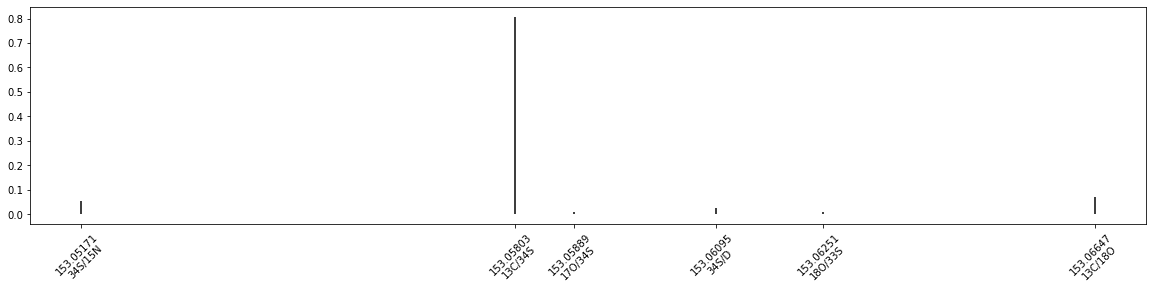

In [30]:
#####PREDICT FULL SPECTRUM (NO FRAGMENT) #####
#####CUT OFF ISOTOPOLOGUES WITH LOW REL ABUNDANCE #####
selectedIsotopologues = M3
lowAbundanceCutOff = 0.01
massError = -0.000


predictSpectrum = {}
for key, item in selectedIsotopologues.items():
    mass = computeMass(key, siteElements)
    correctedMass = mass + massError
    subs = computeSubs(key, siteElements)
    
    if correctedMass not in predictSpectrum:
        predictSpectrum[correctedMass] = {'Abs. Abundance':0}
        
        if 'Sub' not in predictSpectrum[correctedMass]:
            predictSpectrum[correctedMass]['Sub'] = subs
            
    predictSpectrum[correctedMass]['Abs. Abundance'] += item['Conc']
    
totalAbundance = 0
for key, item in predictSpectrum.items():
    totalAbundance += item['Abs. Abundance']
    
massPlot = []
relAbundPlot = []
subPlot = []
for key, item in predictSpectrum.items():
    item['Rel. Abundance'] = item['Abs. Abundance'] / totalAbundance
    massPlot.append(key)
    relAbundPlot.append(item['Rel. Abundance'])
    subPlot.append(item['Sub'])
    
fig, ax = plt.subplots(figsize = (20,4))
massPlotcutOff = []
subPlotcutOff = []
for i in range(len(massPlot)):
    if relAbundPlot[i] > lowAbundanceCutOff:
        ax.vlines(massPlot[i], 0, relAbundPlot[i])
        massPlotcutOff.append(massPlot[i])
        subPlotcutOff.append(subPlot[i])
ax.set_xticks(massPlotcutOff)
labels = [str(round(x,5)) +'\n' + y for x,y in zip(massPlotcutOff,subPlotcutOff)]
ax.set_xticklabels(labels,rotation = 45);
    

(107.035, 107.07)

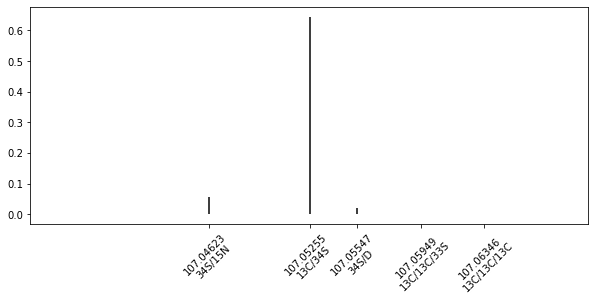

In [31]:
##### PREDICT SPECTRUM WITH FRAGMENTATION #####
selectedIsotopologues = M3
lowAbundanceCutOff = 0.001
massError = 0.000
fragment = expandFrag(frag_104, numberAtSite)
bounds = None



##### Fragment Isotopologues #####
fragmentedDict = {}
for isotopologue, data in selectedIsotopologues.items():
    frag = [fragMult(x,y) for x, y in zip(fragment, isotopologue)]
    newIsotopologue = ''.join(frag)
    if newIsotopologue not in fragmentedDict:
        fragmentedDict[newIsotopologue] = 0
    fragmentedDict[newIsotopologue] += data['Conc']

selectedIsotopologues = fragmentedDict


##### Predict Spectrum #####
predictSpectrum = {}
for key, item in selectedIsotopologues.items():
    mass = computeMass(key, siteElements)
    correctedMass = mass + massError
    subs = computeSubs(key, siteElements)
    
    if correctedMass not in predictSpectrum:
        predictSpectrum[correctedMass] = {'Abs. Abundance':0}
        
        if 'Sub' not in predictSpectrum[correctedMass]:
            predictSpectrum[correctedMass]['Sub'] = subs
            
    predictSpectrum[correctedMass]['Abs. Abundance'] += item
    
totalAbundance = 0
for key, item in predictSpectrum.items():
    totalAbundance += item['Abs. Abundance']
    
massPlot = []
relAbundPlot = []
subPlot = []
for key, item in predictSpectrum.items():
    item['Rel. Abundance'] = item['Abs. Abundance'] / totalAbundance
    massPlot.append(key)
    relAbundPlot.append(item['Rel. Abundance'])
    subPlot.append(item['Sub'])
    
fig, ax = plt.subplots(figsize = (10,4))
massPlotcutOff = []
subPlotcutOff = []
for i in range(len(massPlot)):
    if relAbundPlot[i] > lowAbundanceCutOff:
        ax.vlines(massPlot[i], 0, relAbundPlot[i])
        massPlotcutOff.append(massPlot[i])
        subPlotcutOff.append(subPlot[i])
ax.set_xticks(massPlotcutOff)
labels = [str(round(x,5)) +'\n' + y for x,y in zip(massPlotcutOff,subPlotcutOff)]
ax.set_xticklabels(labels,rotation = 45);
if bounds != None:
    ax.set_xlim(bounds[0],bounds[1])
ax.set_xlim(107.035, 107.07)
    

In [32]:
###See below for an interesting sidenote...

In [33]:
f61 = {}
frag_61Full = expandFrag(frag_61, numberAtSite)
for isotopologue, v in clumpD.items():
    frag = [fragMult(x,y) for x, y in zip(frag_61Full, isotopologue)]
    newIsotopologue = ''.join(frag)
    if newIsotopologue not in f61:
        f61[newIsotopologue] = {'Conc':0,'Number':0,'Sources':0,'Mass':0,'Subs':''}
    f61[newIsotopologue]['Conc'] += v['Conc']
    f61[newIsotopologue]['Number'] += v['Number']
    f61[newIsotopologue]['Sources'] += 1
    f61[newIsotopologue]['Mass'] = computeMass(newIsotopologue, siteElements)
    f61[newIsotopologue]['Subs'] = computeSubs(newIsotopologue, siteElements)

In [34]:
f61

{'00xxxxx0x00000xxxxxxx': {'Conc': 0.928936231216479,
  'Number': 18432,
  'Sources': 5184,
  'Mass': 61.01119633,
  'Subs': ''},
 '00xxxxx0x00001xxxxxxx': {'Conc': 0.0002604439932737,
  'Number': 36864,
  'Sources': 5184,
  'Mass': 62.017473075999995,
  'Subs': 'D'},
 '00xxxxx0x00011xxxxxxx': {'Conc': 1.8255040376540284e-08,
  'Number': 18432,
  'Sources': 5184,
  'Mass': 63.02374982199999,
  'Subs': 'D/D'},
 '00xxxxx0x00100xxxxxxx': {'Conc': 0.0003255549915921264,
  'Number': 55296,
  'Sources': 5184,
  'Mass': 62.017473075999995,
  'Subs': 'D'},
 '00xxxxx0x00101xxxxxxx': {'Conc': 9.127520188270123e-08,
  'Number': 110592,
  'Sources': 5184,
  'Mass': 63.02374982199999,
  'Subs': 'D/D'},
 '00xxxxx0x00111xxxxxxx': {'Conc': 6.397661450362309e-12,
  'Number': 55296,
  'Sources': 5184,
  'Mass': 64.030026568,
  'Subs': 'D/D/D'},
 '00xxxxx0x01100xxxxxxx': {'Conc': 3.8031334117792245e-08,
  'Number': 55296,
  'Sources': 5184,
  'Mass': 63.02374982199999,
  'Subs': 'D/D'},
 '00xxxxx0x01101x

In [35]:
subList = []
numList = []
sourceList = []
iD = []
for i, v in f61.items():
    subList.append(v['Subs'])
    numList.append(v['Number'])
    sourceList.append(v['Sources'])
    iD.append(i)
    
    

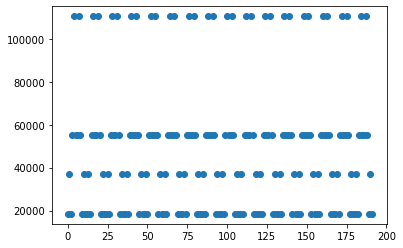

In [36]:
###The number of isotopologues contributing to every fragment of the 61 fragment of methionine. 
###Each is a scalar multiple of some constant; the scalar depends on the symmetry number of the isotopologue. 
###I don't know what to do with this information, but it is interesting. At some point there may be a clever
###computational way to take advantage of it. 

###Something similar occurs with the fine isotope structure of directly fragmented peaks. 

plt.scatter(range(len(numList)),numList)

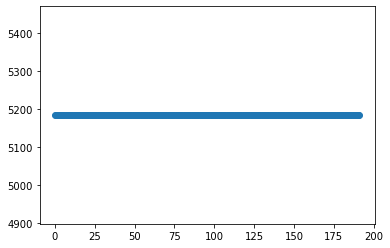

In [37]:
###Here, divide each by the number of sources; i.e. the number of sources is equal to the scalar. 
plt.scatter(range(len(sourceList)),sourceList)

In [38]:
3456 * len(sourceList)

663552

In [39]:
len(sourceList)

192